# Libraries

In [1]:
import nest
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Useful functions

In [2]:
def run_brunel_network(N_total=10000, epsilon=0.1, J_ex=0.1, g=5.0, eta=2.0, sim_time=1100.0):
    '''
    Simulates a Brunel network of spiking neurons using NEST.
    Parameters:
    - N_total: Total number of neurons in the network.
    - epsilon: Connection probability.
    - J_ex: Excitatory synaptic weight amplitude (mV).
    - g: Relative inhibitory strength (J_in = -g * J_ex).
    - eta: External rate relative to threshold.
    - sim_time: Duration of the simulation in milliseconds.
    '''
    # NEST Initialization
    # -------------------
    nest.ResetKernel()
    nest.total_num_virtual_procs = 5
    nest.set_verbosity("M_WARNING")
    nest.rng_seed = 67

    # Parameter Definition
    # -----------------------
    # Network parameters
    NE = int(0.8 * N_total)    # Number of Excitatory neurons
    NI = int(0.2 * N_total)    # Number of Inhibitory neurons
    
    # Connection parameters
    CE = int(epsilon * NE)     # Indegree from Excitatory
    CI = int(epsilon * NI)     # Indegree from Inhibitory

    # Neuron parameters (from Gewaltig et al. 2015)
    tauMem = 20.0  # time constant of membrane potential in ms
    CMem = 1.0  # capacitance of membrane in in pF
    theta = 20.0  # membrane threshold potential in mV
    neuron_params = {
        "C_m": CMem,
        "tau_m": tauMem,
        "t_ref": 2.0,
        "E_L": 0.0,
        "V_reset": 10.0,
        "V_th": theta,
    }
        
    # Synaptic weights
    J_in = -g * J_ex           # Inhibitory weight amplitude
    delay = 1.5                # Synaptic delay (ms)

    # External drive parameters
    nu_th = (theta / (J_ex * CE * tauMem)) * 1000.0   # Threshold rate (Hz) - approximated for parameters
    nu_ext = eta * nu_th       # External Poisson rate (Hz)
    p_rate = nu_ext * CE # Poisson generator rate (spikes/s)

    # Simulation parameters
    dt = 0.1                   # Simulation resolution (ms)

    nest.resolution = dt
    nest.print_time = True
    nest.overwrite_files = True

    print(f"Building network with {N_total} neurons...")

    # Create Nodes
    # ---------------
    # Create neurons (iaf_psc_delta is standard for Brunel 2000)
    nodes_ex = nest.Create("iaf_psc_delta", NE, params=neuron_params)
    nodes_in = nest.Create("iaf_psc_delta", NI, params=neuron_params)
    
    # Create external noise (Poisson generator)
    noise = nest.Create("poisson_generator", params={"rate": p_rate})

    # Create spike recorder for excitatory and inhibitory neurons
    espikes = nest.Create("spike_recorder")
    espikes.set(label="brunel-py-ex")
    ispikes = nest.Create("spike_recorder")
    ispikes.set(label="brunel-py-in")

    # Connect Network
    # ------------------
    # Configure synapse specifications
    syn_ex = {"weight": J_ex, "delay": delay}
    syn_in = {"weight": J_in, "delay": delay}
    
    # Configure connection rule (Fixed Indegree)
    conn_params_ex = {"rule": "fixed_indegree", "indegree": CE}
    conn_params_in = {"rule": "fixed_indegree", "indegree": CI}

    print("Connecting devices...")

    nest.CopyModel("static_synapse", "excitatory", syn_ex)
    nest.CopyModel("static_synapse", "inhibitory", syn_in)
    
    # Connect External Noise -> All Neurons
    nest.Connect(noise, nodes_ex + nodes_in, "all_to_all", syn_spec="excitatory")
    # Connect Excitatory Population -> All Neurons
    nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, syn_ex)
    # Connect Inhibitory Population -> All Neurons
    nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, syn_in)

    # Connect Neurons -> Spike Recorder
    nest.Connect(nodes_ex, espikes, syn_spec="static_synapse")
    nest.Connect(nodes_in, ispikes, syn_spec="static_synapse")

    # Run Simulation
    # -----------------
    print(f"Simulating for {sim_time} ms...")
    start_time = time.time()
    nest.Simulate(sim_time)
    end_time = time.time()
    
    print(f"Simulation finished in {end_time - start_time:.2f} s")

    return espikes, ispikes

In [2]:
def get_population_rate(spike_times, N_neurons, sim_time, dt_bin=2.0):
    '''
    Calculates the instantaneous population rate A(t) and its distribution.
    
    Parameters:
    - spike_times: List or array of spike timestamps (ms)
    - N_neurons: Number of neurons in the population being analyzed
    - sim_time: Total simulation duration (ms)
    - dt_bin: Width of the time bin for calculation (ms). 
              2.0 ms is usually good for capturing fast oscillations.
    '''
    
    # Define time bins
    bins = np.arange(0, sim_time + dt_bin, dt_bin)
    
    # Bin the spikes (Count spikes per bin)
    spike_counts, _ = np.histogram(spike_times, bins=bins)
    
    # Convert Count -> Rate (Hz)
    # Rate = Count / (Number_of_Neurons * Bin_Width_in_Seconds)
    bin_width_sec = dt_bin / 1000.0
    A_t = spike_counts / (N_neurons * bin_width_sec)
    
    # Remove transient
    # The first ~100ms often contains startup artifacts.
    warmup_bins = int(100 / dt_bin) 
    A_t_steady = A_t[warmup_bins:] 
    
    return bins[:-1], A_t, A_t_steady

In [40]:
import matplotlib.pyplot as plt

def plot_brunel_raster(espikes, ispikes, N_ex, sim_time, max_neurons=500):

    ev_ex = nest.GetStatus(espikes)[0]['events']
    ev_in = nest.GetStatus(ispikes)[0]['events']

    plt.figure(figsize=(12, 6))

    # ---- Excitatory ----
    ex_min = ev_ex['senders'].min()
    mask_ex = ev_ex['senders'] < ex_min + max_neurons

    y_ex = ev_ex['senders'][mask_ex] - ex_min
    plt.plot(ev_ex['times'][mask_ex], y_ex,
            '.', markersize=2, color='navy', label='Excitatory')

    # Number of excitatory neurons actually shown
    n_ex_shown = y_ex.max() + 1

    # ---- Inhibitory ----
    in_min = ev_in['senders'].min()
    max_in = max_neurons // 4
    mask_in = ev_in['senders'] < in_min + max_in

    # ✅ Correct offset
    y_in = n_ex_shown + (ev_in['senders'][mask_in] - in_min)

    plt.plot(ev_in['times'][mask_in], y_in,
            '.', markersize=2, color='crimson', label='Inhibitory')

    # ---- Formatting ----
    plt.title("Brunel Network Raster Plot")
    plt.xlabel("Time (ms)")
    plt.ylabel("Neuron index")
    plt.xlim(0, sim_time)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Network analysis

## Mean firing rate of each population

Building network with 10000 neurons...
Connecting devices...
Simulating for 1000.0 ms...

[   0% ] Model time: 0.0 ms, Real-time factor: 0.0000Simulation finished in 2.39 s
[ 100% ] Model time: 1000.0 ms, Real-time factor: 2.2109


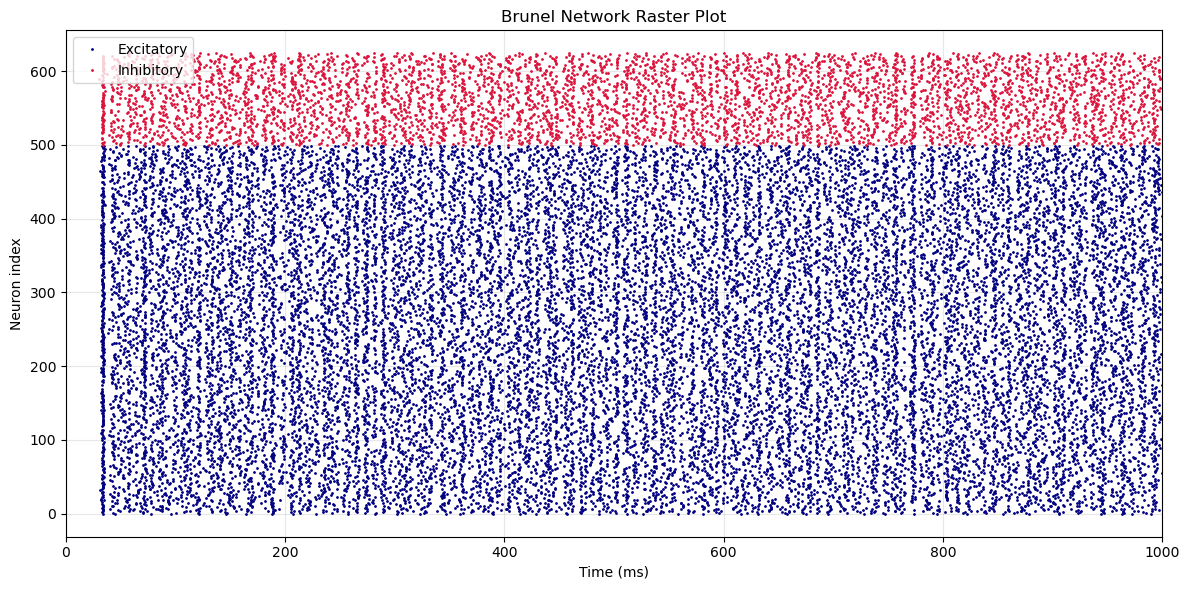

In [44]:
# g=5.0, eta=2.0 usually results in the "Synchronous Irregular" (SI) state
# g=4.5, eta=0.9 usually results in "Asynchronous Irregular" (AI) state
espikes, ispikes = run_brunel_network(
    N_total=10000, 
    g=5.0, 
    eta=2.0, 
    sim_time=1000.0
)

NE = int(0.8 * 10000)
# Plot the results
plot_brunel_raster(espikes, ispikes, NE, sim_time=1000.0, max_neurons=500)

Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...

[   0% ] Model time: 0.0 ms, Real-time factor: 0.0000Simulation finished in 3.25 s
[ 100% ] Model time: 1100.0 ms, Real-time factor: 2.7830
Mean Population Rate: 43.42 Hz
Std Dev of Rate: 21.15 Hz
Mean Excitatory Rate: 43.41 Hz
Std Dev of Excitatory Rate: 21.15 Hz
Mean Inhibitory Rate: 43.45 Hz
Std Dev of Inhibitory Rate: 21.44 Hz


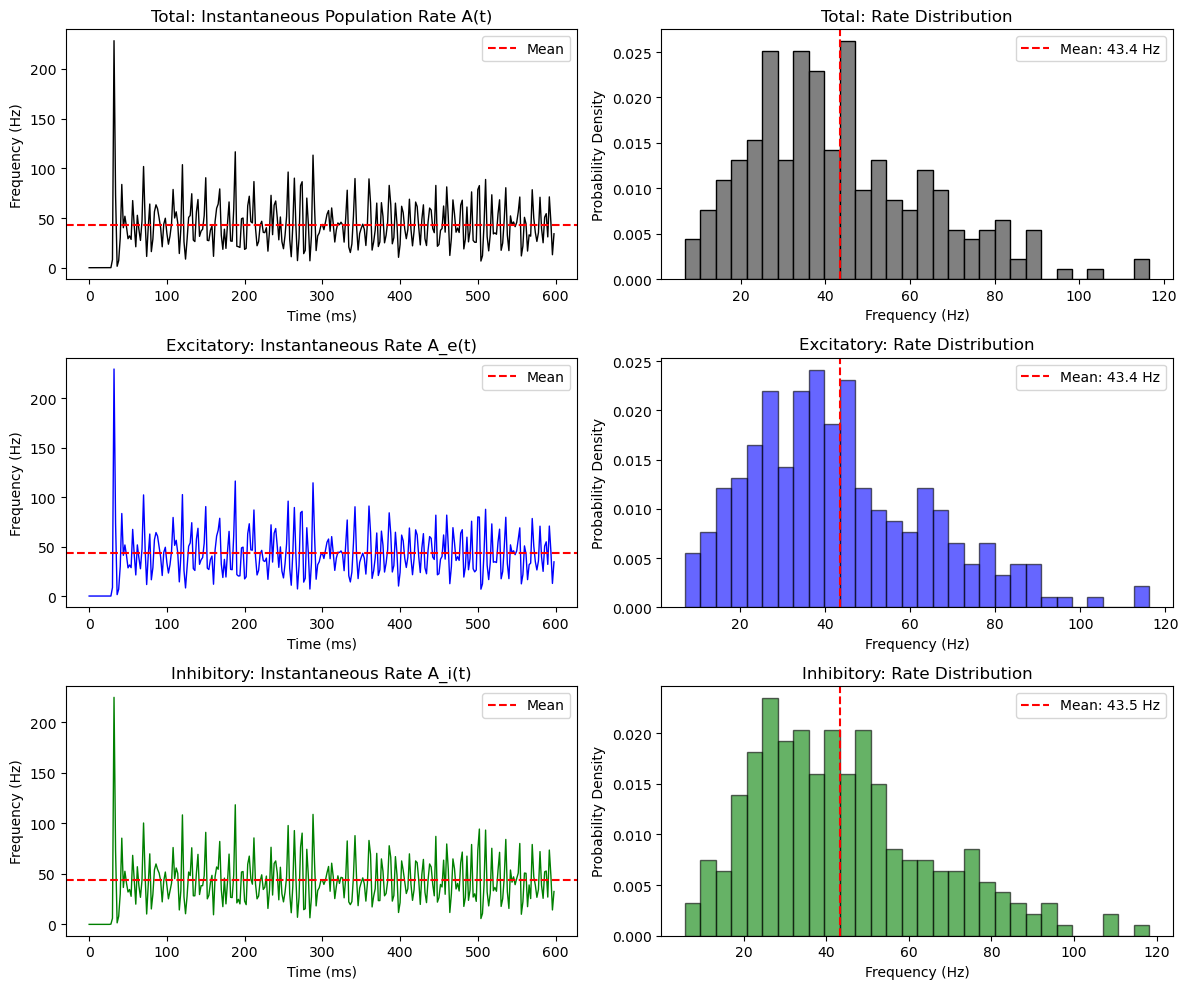

In [45]:
import scipy.stats as stats

sim_time = 600.0
N_total = 10000
NE = int(0.8 * N_total)
NI = int(0.2 * N_total)

espikes, ispikes = run_brunel_network()

spikes_ex = nest.GetStatus(espikes, "events")[0]["times"]
spikes_in = nest.GetStatus(ispikes, "events")[0]["times"]
spikes_all = np.concatenate([spikes_ex, spikes_in])

# Calculate Dynamics
time_axis_e, A_t_e, A_t_steady_e = get_population_rate(spikes_ex, NE, sim_time, dt_bin=2.0)
time_axis_i, A_t_i, A_t_steady_i = get_population_rate(spikes_in, NI, sim_time, dt_bin=2.0)
time_axis, A_t, A_t_steady = get_population_rate(spikes_all, N_total, sim_time, dt_bin=2.0)

# Calculate Statistics
mean_rate = np.mean(A_t_steady)
std_rate = np.std(A_t_steady)
mean_rate_e = np.mean(A_t_steady_e)
std_rate_e = np.std(A_t_steady_e)
mean_rate_i = np.mean(A_t_steady_i)
std_rate_i = np.std(A_t_steady_i)

print(f"Mean Population Rate: {mean_rate:.2f} Hz")
print(f"Std Dev of Rate: {std_rate:.2f} Hz")
print(f"Mean Excitatory Rate: {mean_rate_e:.2f} Hz")
print(f"Std Dev of Excitatory Rate: {std_rate_e:.2f} Hz")
print(f"Mean Inhibitory Rate: {mean_rate_i:.2f} Hz")
print(f"Std Dev of Inhibitory Rate: {std_rate_i:.2f} Hz")

# Create the grid
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the 2D array (3x2) into a 1D array of 6 axes
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# --- TOTAL POPULATION (Black) ---
# Plot A(t) - The Time Series
ax1.plot(time_axis, A_t, color='k', lw=1)
ax1.set_title("Total: Instantaneous Population Rate A(t)")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Frequency (Hz)")
ax1.axhline(mean_rate, color='red', linestyle='--', label='Mean')
ax1.legend(loc="upper right")

# Plot P(A) - The Distribution
ax2.hist(A_t_steady, bins=30, color='gray', edgecolor='black', density=True)
ax2.set_title("Total: Rate Distribution")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Probability Density")
ax2.axvline(mean_rate, color='red', linestyle='--', label=f'Mean: {mean_rate:.1f} Hz')
ax2.legend(loc="upper right")

# --- EXCITATORY (Blue) ---
ax3.plot(time_axis_e, A_t_e, color='b', lw=1)
ax3.set_title("Excitatory: Instantaneous Rate A_e(t)")
ax3.set_xlabel("Time (ms)")
ax3.set_ylabel("Frequency (Hz)")
ax3.axhline(mean_rate_e, color='red', linestyle='--', label='Mean')
ax3.legend(loc="upper right")

ax4.hist(A_t_steady_e, bins=30, color='blue', alpha=0.6, edgecolor='black', density=True)
ax4.set_title("Excitatory: Rate Distribution")
ax4.set_xlabel("Frequency (Hz)")
ax4.set_ylabel("Probability Density")
ax4.axvline(mean_rate_e, color='red', linestyle='--', label=f'Mean: {mean_rate_e:.1f} Hz')
ax4.legend(loc="upper right")

# --- INHIBITORY (Green) ---
ax5.plot(time_axis_i, A_t_i, color='g', lw=1)
ax5.set_title("Inhibitory: Instantaneous Rate A_i(t)")
ax5.set_xlabel("Time (ms)")
ax5.set_ylabel("Frequency (Hz)")
ax5.axhline(mean_rate_i, color='red', linestyle='--', label='Mean')
ax5.legend(loc="upper right")

ax6.hist(A_t_steady_i, bins=30, color='green', alpha=0.6, edgecolor='black', density=True)
ax6.set_title("Inhibitory: Rate Distribution")
ax6.set_xlabel("Frequency (Hz)")
ax6.set_ylabel("Probability Density")
ax6.axvline(mean_rate_i, color='red', linestyle='--', label=f'Mean: {mean_rate_i:.1f} Hz')
ax6.legend(loc="upper right")

plt.tight_layout()
plt.show()

We apply a statical comparison test to verify if these distributions are equivalent:

Comparison                     | KS Statistic | P-Value      | Result
---------------------------------------------------------------------------
Excitatory vs Inhibitory       | 0.0320       | 1.00e+00   | Equivalent
Excitatory vs Combined         | 0.0160       | 1.00e+00   | Equivalent
Inhibitory vs Combined         | 0.0280       | 1.00e+00   | Equivalent


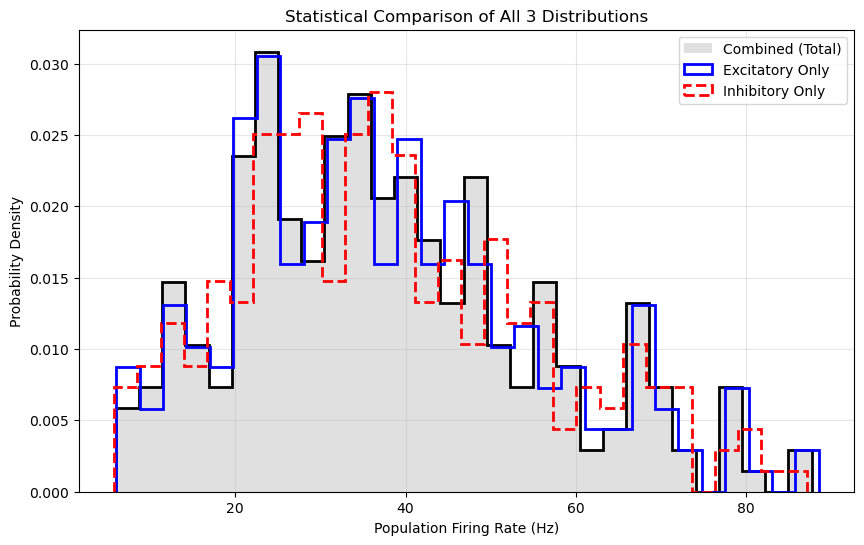

In [7]:
comparisons = [
    ("Excitatory vs Inhibitory", A_t_steady_e, A_t_steady_i),
    ("Excitatory vs Combined",   A_t_steady_e, A_t_steady),
    ("Inhibitory vs Combined",   A_t_steady_i, A_t_steady)
]

print(f"{'Comparison':<30} | {'KS Statistic':<12} | {'P-Value':<12} | {'Result'}")
print("-" * 75)

for label, data1, data2 in comparisons:
    stat, p_val = stats.ks_2samp(data1, data2)
    # If p < 0.05, we reject the null hypothesis (they are different)
    result = "DIFFERENT" if p_val < 0.05 else "Equivalent"
    print(f"{label:<30} | {stat:.4f}       | {p_val:.2e}   | {result}")

# Superimposed Plotting
# ------------------------
plt.figure(figsize=(10, 6))

# We use 'step' histograms to see the lines clearly without blocking each other
# Plot Combined (Black filled) - as the "background" reference
plt.hist(A_t_steady, bins=30, density=True, color='lightgray', alpha=0.7, label='Combined (Total)')
plt.hist(A_t_steady, bins=30, density=True, histtype='step', color='black', lw=2)

# Plot Excitatory (Blue line)
plt.hist(A_t_steady_e, bins=30, density=True, histtype='step', color='blue', lw=2, label='Excitatory Only')

# Plot Inhibitory (Red line)
plt.hist(A_t_steady_i, bins=30, density=True, histtype='step', color='red', lw=2, linestyle='--', label='Inhibitory Only')

plt.title("Statistical Comparison of All 3 Distributions")
plt.xlabel("Population Firing Rate (Hz)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Grid search and classification

In [3]:
def analyze_state(events, sim_time):
    '''Calculates CV (Irregularity) and Fano Factor/Synchrony'''
    raw_times = events["times"]
    raw_senders = events["senders"]
    
    # FILTER: Keep only spikes after the transient
    mask = raw_times > 100.0
    spike_times = raw_times[mask]
    senders = raw_senders[mask]
    
    if len(spike_times) < 100:
        return 0, 0 # Dead network

    # --- Calculate CV (Irregularity) ---
    cvs = []
    unique_senders = np.unique(senders)
    
    for neuron_id in unique_senders:
        st = spike_times[senders == neuron_id]
        if len(st) > 3:
            isi = np.diff(st)
            mean_isi = np.mean(isi)
            std_isi = np.std(isi)
            if mean_isi > 0:
                cvs.append(std_isi / mean_isi)
    
    avg_cv = np.mean(cvs) if cvs else 0

    # --- Calculate Synchrony Index (Global Oscillation) ---
    fine_bins = np.arange(0, sim_time, 0.5)
    pop_hist, _ = np.histogram(spike_times, bins=fine_bins)
    
    if np.mean(pop_hist) > 0:
        # A simple synchrony measure: StdDev of population rate normalized by mean
        synchrony = np.var(pop_hist) / np.mean(pop_hist)
    else:
        synchrony = 0
        
    return avg_cv, synchrony

In [4]:
import pandas as pd
import numpy as np
import nest

# Define your parameter space
g_values = np.linspace(0.0, 8.0, 16)    # Inhibition ratio
eta_values = np.linspace(0.0, 4.0, 8)   # External Drive
output_file = "brunel_grid_search_spikes.csv"

# Initialize an empty list to store DataFrames (more efficient than appending to CSV line-by-line)
# OR initialize the file if you expect massive data (to save memory).
# Below is the Memory-Efficient approach: writing to disk every iteration.

print(f"Starting Grid Search ({len(g_values)}x{len(eta_values)} simulations)...")

# 1. Create the CSV file and write the header
header = ["g", "eta", "neuron_id", "spike_time_ms", "type"]
pd.DataFrame(columns=header).to_csv(output_file, index=False)

for g in g_values:
    for eta in eta_values:
        print(f"Simulating g={g:.1f}, eta={eta:.1f}...", end="\r")
        
        # Run Simulation
        # Note: Ensure your run_brunel_network function returns espikes, ispikes
        espikes, ispikes = run_brunel_network(g=g, eta=eta, sim_time=1100.0)

        # Extract Excitatory Spikes
        ex_events = nest.GetStatus(espikes, "events")[0]
        df_ex = pd.DataFrame({
            "g": g,
            "eta": eta,
            "neuron_id": ex_events["senders"],
            "spike_time_ms": ex_events["times"],
            "type": "excitatory"
        })

        # Extract Inhibitory Spikes
        in_events = nest.GetStatus(ispikes, "events")[0]
        df_in = pd.DataFrame({
            "g": g,
            "eta": eta,
            "neuron_id": in_events["senders"],
            "spike_time_ms": in_events["times"],
            "type": "inhibitory"
        })

        # Combine and Append to CSV
        # mode='a' appends to the file; header=False prevents writing the header again
        combined_df = pd.concat([df_ex, df_in])
        combined_df.to_csv(output_file, mode='a', header=False, index=False)

print(f"\nAnalysis Complete. Data saved to {output_file}")

Starting Grid Search (16x8 simulations)...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Simulation finished in 0.42 s

[ 100% ] Model time: 1100.0 ms, Real-time factor: 0.1897
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...

[   0% ] Model time: 0.0 ms, Real-time factor: 0.0000Simulation finished in 0.89 s
Building network with 10000 neurons...
Connecting devices...
[   4% ] Model time: 37.0 msSimulating for 1100.0 ms...: 19.0 ms, Real-time factor: 0.6593
[ 100% ] Model time: 1100.0 ms, Real-time factor: 0.6095

[   7% ] Model time: 69.0 ms, Real-time factor: 1.8190

KeyboardInterrupt: 

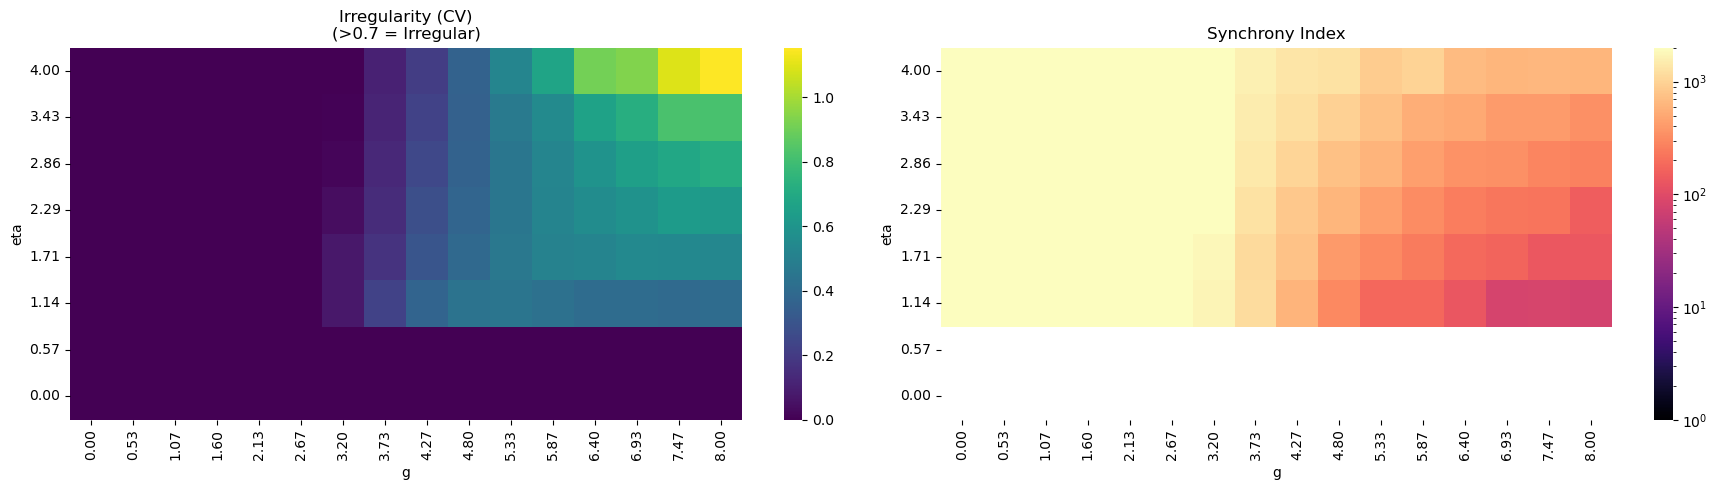

In [34]:
import seaborn as sns
from matplotlib.colors import LogNorm

df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Pivot data for heatmaps
pivot_cv = df.pivot(index="eta", columns="g", values="CV")
pivot_sync = df.pivot(index="eta", columns="g", values="Synchrony")

# 1. CV Heatmap (Regular vs Irregular)
sns.heatmap(pivot_cv, ax=axes[0], cmap="viridis", annot=False)
axes[0].set_title("Irregularity (CV)\n(>0.7 = Irregular)")
axes[0].invert_yaxis() # Standard graph orientation

# 2. Synchrony Heatmap (Async vs Sync)
sns.heatmap(pivot_sync, ax=axes[1], cmap="magma", 
            norm=LogNorm(vmin=1, vmax=2000))
axes[1].set_title("Synchrony Index")
axes[1].invert_yaxis()

for ax in axes:
    ax.set_xticklabels([f"{float(t.get_text()):.2f}" for t in ax.get_xticklabels()])
    ax.set_yticklabels([f"{float(t.get_text()):.2f}" for t in ax.get_yticklabels()])

plt.tight_layout()
plt.show()

Cluster Analysis:
ID  | Mean CV  | Mean Sync  | Inferred State
--------------------------------------------------
0   | 0.45     | 446.98       | SR (Sync Regular)
1   | 0.03     | 1968.45       | SR (Sync Regular)
2   | -0.00     | 0.00       | AR (Async Regular)
3   | 0.82     | 508.68       | SI (Sync Irregular)


/tmp/ipykernel_176756/2843491754.py:77: MatplotlibDeprecationWarning:The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


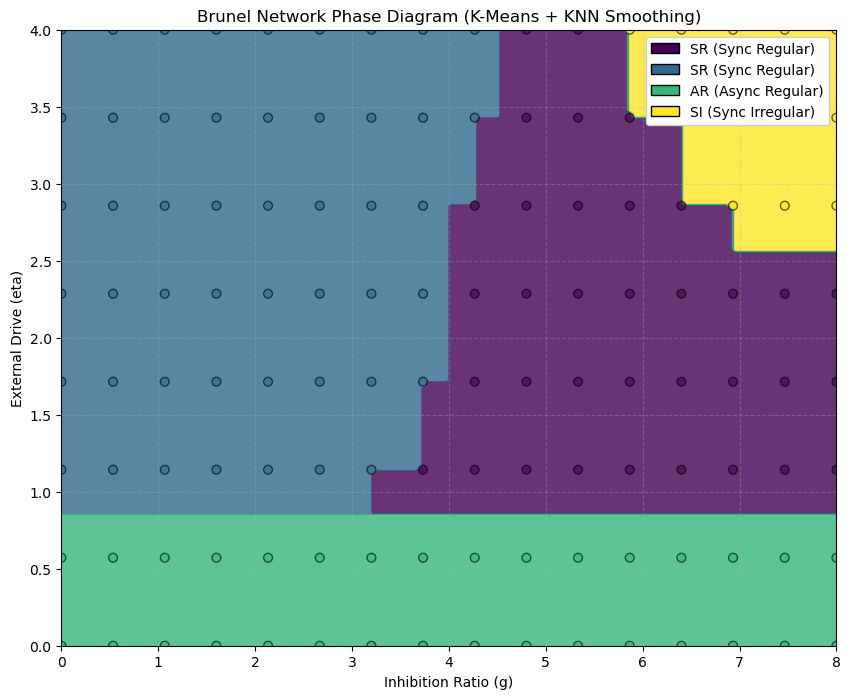

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# 1. Prepare Data
# ----------------
# We assume 'df' is your DataFrame from the simulation results
# df = pd.DataFrame(results) 

# Extract metrics for clustering
X_metrics = df[['CV', 'Synchrony']].values

# Scale metrics (Crucial: Synchrony can be ~5.0 while CV is ~1.0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_metrics)

# 2. Run Unsupervised Clustering (K-Means)
# ----------------------------------------
# We ask for 4 clusters (SR, SI, AR, AI)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster_ID'] = kmeans.fit_predict(X_scaled)

# 3. Auto-Labeling the Clusters
# -----------------------------
# K-Means assigns IDs (0,1,2,3) randomly. We need to figure out which physical
# state corresponds to each ID by looking at the cluster centers.
cluster_names = {}
centers = scaler.inverse_transform(kmeans.cluster_centers_) # Back to original units

print("Cluster Analysis:")
print(f"{'ID':<3} | {'Mean CV':<8} | {'Mean Sync':<10} | {'Inferred State'}")
print("-" * 50)

for i, center in enumerate(centers):
    mean_cv, mean_sync = center
    
    # Heuristics to name the state automatically
    is_irregular = mean_cv > 0.7  # Threshold for naming
    is_sync = mean_sync > 8.0     # Threshold for naming
    
    if is_sync and not is_irregular: label = "SR (Sync Regular)"
    elif is_sync and is_irregular:   label = "SI (Sync Irregular)"
    elif not is_sync and is_irregular: label = "AI (Async Irregular)"
    else: label = "AR (Async Regular)"
    
    cluster_names[i] = label
    print(f"{i:<3} | {mean_cv:.2f}     | {mean_sync:.2f}       | {label}")

# 4. Train KNN to Create the Surface
# ----------------------------------
# We train a classifier to predict the "State" based on g and eta
knn = KNeighborsClassifier(n_neighbors=3) # Small k keeps boundaries sharp
X_params = df[['g', 'eta']].values
y_labels = df['Cluster_ID'].values
knn.fit(X_params, y_labels)

# 5. Generate Grid for Contour Plot
# ---------------------------------
resolution = 200 # 200x200 grid for smooth curves
g_range = np.linspace(df['g'].min(), df['g'].max(), resolution)
eta_range = np.linspace(df['eta'].min(), df['eta'].max(), resolution)
xx, yy = np.meshgrid(g_range, eta_range)

# Flatten grid to predict, then reshape back
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid_points)
Z = Z.reshape(xx.shape)

# 6. Plot
# -------
plt.figure(figsize=(10, 8))

# Define colors matching the 4 clusters
cmap = plt.cm.get_cmap('viridis', 4)

# The Contour Plot (Filled regions)
contour = plt.contourf(xx, yy, Z, levels=np.arange(-0.5, 4, 1), cmap=cmap, alpha=0.8)

# Overlay the original simulation points (optional, to show ground truth)
scatter = plt.scatter(df['g'], df['eta'], c=df['Cluster_ID'], cmap=cmap, 
                      edgecolor='k', s=40, alpha=0.6, label='Sim Points')

# Custom Legend
# We create "fake" handles to make the legend readable with our custom names
from matplotlib.patches import Patch
legend_handles = []
for i in range(4):
    color = cmap(i / 3) # Normalize 0..3 to 0..1
    name = cluster_names.get(i, f"Cluster {i}")
    legend_handles.append(Patch(facecolor=color, edgecolor='k', label=name))

plt.legend(handles=legend_handles, loc='upper right', framealpha=1.0)
plt.title("Brunel Network Phase Diagram (K-Means + KNN Smoothing)")
plt.xlabel("Inhibition Ratio (g)")
plt.ylabel("External Drive (eta)")
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

## Evaluating the Tsalis Entropy

In [10]:
import numpy as np
import scipy.stats

def calculate_tsallis_entropy(time_series, q=2.0, bins=30):
    '''
    Calculates Tsallis Entropy of a time series distribution.
    
    Parameters:
    - time_series: Array of instantaneous rates A(t)
    - q: Entropic index (q=1 returns Shannon Entropy)
    - bins: Number of histogram bins to estimate P(A)
    '''
    # Estimate probability distribution P(A)
    counts, _ = np.histogram(time_series, bins=bins, density=False)
    
    # Normalize to get probabilities (sum must be 1)
    p = counts / np.sum(counts)
    
    # Filter out zero probabilities to avoid math errors
    p = p[p > 0]
    
    # Calculate Entropy
    if np.isclose(q, 1.0):
        # Limit q->1 is Shannon Entropy: -Sum(p * log(p))
        return scipy.stats.entropy(p)
    else:
        # Tsallis Formula: (1 - Sum(p^q)) / (q - 1)
        sum_pq = np.sum(p ** q)
        return (1.0 - sum_pq) / (q - 1.0)

In [11]:
shannon = calculate_tsallis_entropy(A_t_steady, q=1.0) # Standard info 
tsallis_2 = calculate_tsallis_entropy(A_t_steady, q=2.0) # High-rate focus
tsallis_half = calculate_tsallis_entropy(A_t_steady, q=0.5) # Rare-event focus